In [1]:
import sys
sys.path.insert(1, '/home/zpengac/pose/EFARS/')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import random
from datetime import datetime
import time
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from models.sem_gcn import SemGCN, GCNLSTM, GCNTransformer
from models.pose2mesh import PoseNet
from data.human36m import Human36M2DTo3DDataset, Human36M2DTo3DTemporalDataset, Human36MMetadata, image_coordinates
from utils.transform import do_2d_to_3d_transforms, denormalize
from utils.misc import AverageMeter, seed_everything
from utils.graph import adj_mx_from_edges
from utils.visualization import show_pos2d_with_projected_pos3d, show_pos3d

In [2]:
seed_everything(1120)

root_path = '/scratch/PI/cqf/datasets/h36m'
img_path = root_path + '/img'
pos2d_path = root_path + '/pos2d'
pos3d_path = root_path + '/pos3d'

img_fns = glob(img_path+'/*.jpg')
random.shuffle(img_fns)
test_fns = img_fns[12000:14000]

In [3]:
#test_dataset = Human36M2DTo3DDataset(test_fns, pos2d_path, pos3d_path, transforms=do_2d_to_3d_transforms)
test_dataset = Human36M2DTo3DTemporalDataset(test_fns, pos2d_path, pos3d_path, length=5)

In [4]:
import json
cps = json.load(open(Human36MMetadata.camera_parameters_path, 'r'))

In [5]:
from collections import OrderedDict
#net = PoseNet(num_joint=17, pretrained=True)
net = GCNTransformer(adj=adj_mx_from_edges(Human36MMetadata.num_joints, Human36MMetadata.skeleton_edges, sparse=False), hid_dim=128)
checkpoint = torch.load('/home/zpengac/pose/EFARS/estimator/checkpoints/GCNTransformer-120-1e-3-ohno/best-checkpoint-007epoch.bin', map_location=torch.device('cpu'))
state_dict = checkpoint['model_state_dict']
new_sd = OrderedDict()
for k, v in state_dict.items():
    new_sd[k[7:]] = v
net.load_state_dict(new_sd)
net.eval()

GCNTransformer(
  (gcn): SemGCN(
    (gconv_input): Sequential(
      (0): _GraphConv(
        (gconv): SemGraphConv (2 -> 128)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (gconv_layers): Sequential(
      (0): _ResGraphConv(
        (gconv1): _GraphConv(
          (gconv): SemGraphConv (128 -> 128)
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (gconv2): _GraphConv(
          (gconv): SemGraphConv (128 -> 128)
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
      )
      (1): _ResGraphConv(
        (gconv1): _GraphConv(
          (gconv): SemGraphConv (128 -> 128)
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (gconv2): _GraphCon

In [6]:
#den_2d = lambda img: denormalize(img, Human36MMetadata.pos2d_mean, Human36MMetadata.pos2d_std)
#den_3d = lambda img: denormalize(img, Human36MMetadata.pos3d_mean, Human36MMetadata.pos3d_std)

In [6]:
pos2d, pos3d = test_dataset[999]
pos2d = pos2d.unsqueeze(0)
pos3d = pos3d.unsqueeze(0)
pos3d_in = pos3d[:,:-1,...]
pos3d_out = pos3d[:,1:,...]
pred = net(pos2d.float(), pos3d_in.float())

pred = pred.squeeze().detach()
pos2d = pos2d.squeeze().detach()
pos3d_in = pos3d_in.squeeze().detach()
pos3d_out = pos3d_out.squeeze().detach()

In [7]:
#pos2d = denormalize(pos2d, Human36MMetadata.pos2d_mean, Human36MMetadata.pos2d_std)
#pred = denormalize(pred, Human36MMetadata.pos3d_mean, Human36MMetadata.pos3d_std)
pos2d = torch.from_numpy(image_coordinates(pos2d.numpy(), 1000, 1000))
pred *= 1000

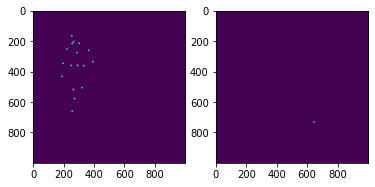

In [9]:
#pred[pred < 0.01] = 0
show_pos2d_with_projected_pos3d(pos2d, pred, (1000, 1000), P)

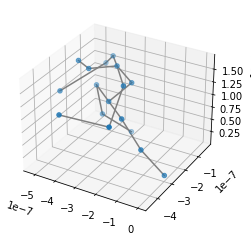

In [9]:
show_pos3d(pos3d_out[2] * 1000, Human36MMetadata.skeleton_edges)

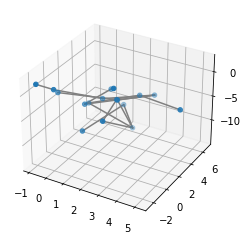

In [8]:
show_pos3d(pred[2], Human36MMetadata.skeleton_edges)